In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [79]:
# Load data from the CSV file
data_pays = pd.read_csv("exports_pays.csv", delimiter=',')

This code is designed to prepare time series data for a given product, train and forecast using ARIMA and Prophet models, visualize the forecasts, and calculate the Mean Squared Error (MSE) for each product. The code works through the following steps:

1- Data Preparation: Extracts and aggregates export values for a specific product from the dataset.
2-ARIMA Model Training and Forecasting: Splits the data into training and test sets, fits an ARIMA model, and makes forecasts.
3-Prophet Model Training and Forecasting: Formats the data, fits a Prophet model, and makes forecasts.
4-Visualization: Plots the historical data and forecasts from both models for comparison.
5-Error Calculation: Computes the MSE for the forecasts from both models.
6-Forecasting for Multiple Products: Iterates through a list of products, performs the above steps, and prints the MSE for each product.

02:56:31 - cmdstanpy - INFO - Chain [1] start processing
02:56:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


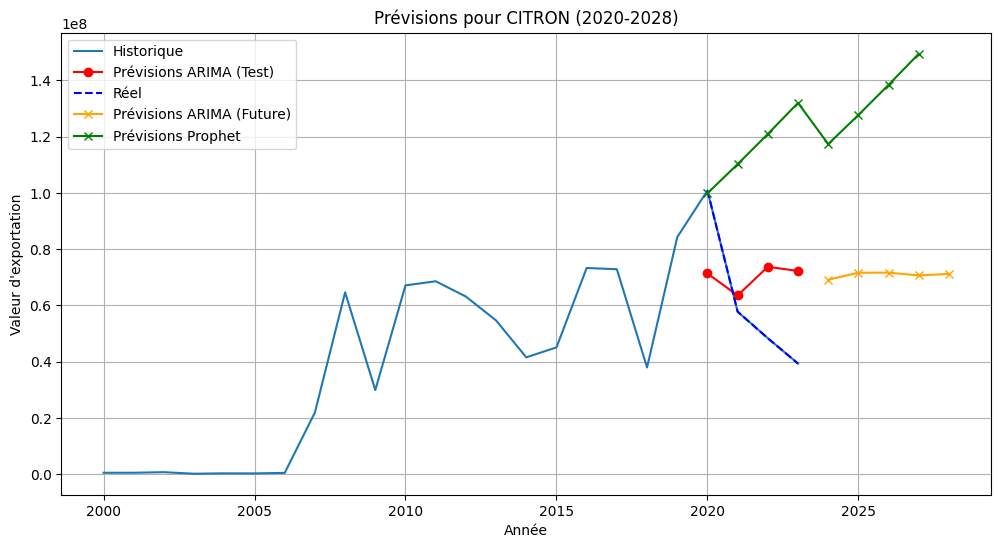

ARIMA MSE pour CITRON: 658237083653815.2
Prophet MSE pour CITRON: 4155214760425653.0


c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
02:56:32 - cmdstanpy - INFO - Chain [1] start processing
02:56:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


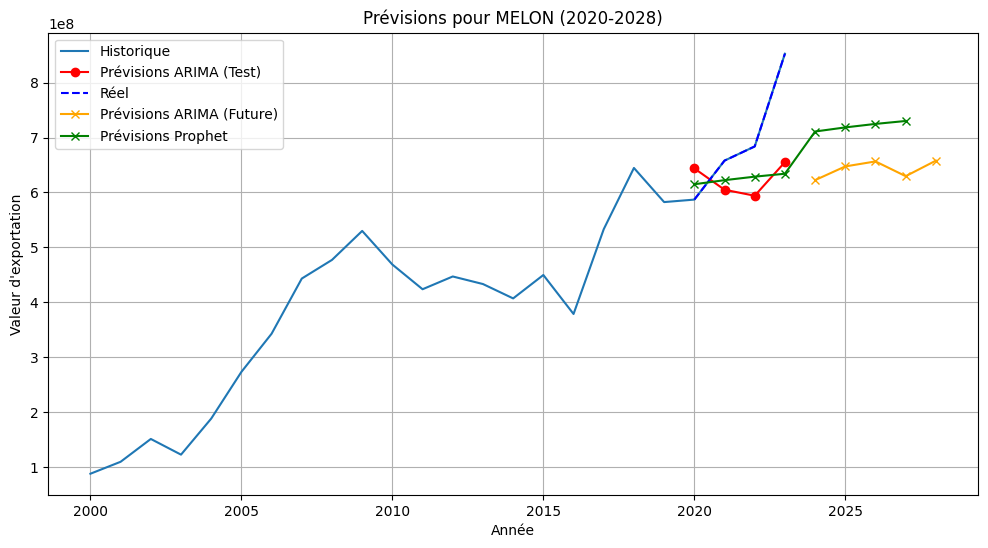

ARIMA MSE pour MELON: 1.3275122826871442e+16
Prophet MSE pour MELON: 1.321871725029678e+16


02:56:33 - cmdstanpy - INFO - Chain [1] start processing
02:56:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


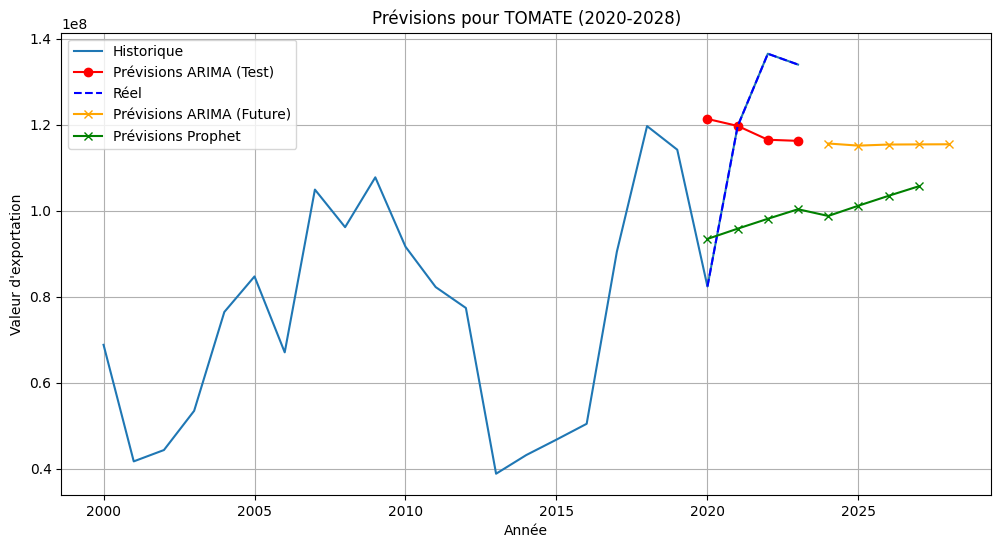

ARIMA MSE pour TOMATE: 558402622353727.8
Prophet MSE pour TOMATE: 823873880119498.2


In [80]:

# Fonction pour préparer la série temporelle pour un produit donné
def prepare_timeseries(data, produit):
    product_data = data[data['produit'] == produit]
    # Sélectionner uniquement les colonnes de valeurs d'exportation par année
    valeur_columns = [col for col in data.columns if col.startswith('valeur_')]
    product_data = product_data[valeur_columns]
    product_data = product_data.sum(axis=0)
    product_data.index = pd.Index(range(2000, 2000 + len(product_data)))
    return product_data

# Fonction pour entraîner et prévoir avec un modèle ARIMA
def train_and_forecast_arima(product_series, train_end_year=2019, steps=5):
    train_size = train_end_year - 2000 + 1
    train, test = product_series[:train_size], product_series[train_size:]
    
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test) + steps)
    return model_fit, forecast[:len(test)], forecast[len(test):], test

# Fonction pour entraîner et prévoir avec Prophet
def train_and_forecast_prophet(product_series, train_end_year=2019, steps=5):
    df = product_series.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    train = df[df['ds'].dt.year <= train_end_year]
    test_years = df[df['ds'].dt.year > train_end_year]['ds'].dt.year
    
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=steps + len(test_years), freq='Y')
    forecast = model.predict(future)
    
    return model, forecast, test_years

# Fonction pour visualiser les prévisions
def plot_forecast(product, product_series, arima_forecast, arima_test, arima_future_forecast, prophet_forecast, train_end_year=2019):
    plt.figure(figsize=(12, 6))
    plt.plot(product_series, label='Historique')
    
    forecast_years = range(train_end_year + 1, train_end_year + 1 + len(arima_forecast))
    plt.plot(forecast_years, arima_forecast, label='Prévisions ARIMA (Test)', color='red', marker='o')
    plt.plot(forecast_years, arima_test, label='Réel', color='blue', linestyle='dashed')
    
    future_forecast_years = range(train_end_year + 1 + len(arima_forecast), train_end_year + 1 + len(arima_forecast) + len(arima_future_forecast))
    plt.plot(future_forecast_years, arima_future_forecast, label='Prévisions ARIMA (Future)', color='orange', marker='x')
    
    # Afficher uniquement les prévisions Prophet pour les années après la fin de l'ensemble d'entraînement
    prophet_future_forecast = prophet_forecast[prophet_forecast['ds'].dt.year > train_end_year]
    plt.plot(prophet_future_forecast['ds'].dt.year, prophet_future_forecast['yhat'], label='Prévisions Prophet', color='green', marker='x')
    
    plt.title(f'Prévisions pour {product} (2020-2028)')
    plt.xlabel('Année')
    plt.ylabel('Valeur d\'exportation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculer le MSE des prévisions
def calculate_mse(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values)

# Prévoir la demande pour chaque produit
products = ['CITRON', 'MELON', 'TOMATE']
forecast_steps = 5  # Nombre d'étapes de prévision pour 2024 à 2028

for product in products:
    product_series = prepare_timeseries(data_pays, product)
    arima_model_fit, arima_forecast, arima_future_forecast, arima_test = train_and_forecast_arima(product_series, train_end_year=2019, steps=forecast_steps)
    prophet_model, prophet_forecast, test_years = train_and_forecast_prophet(product_series, train_end_year=2019, steps=forecast_steps)
    
    plot_forecast(product, product_series, arima_forecast, arima_test, arima_future_forecast, prophet_forecast, train_end_year=2019)
    
    arima_mse = calculate_mse(arima_test, arima_forecast)
    prophet_test_forecast = prophet_forecast[prophet_forecast['ds'].dt.year.isin(test_years)]['yhat']
    prophet_mse = calculate_mse(arima_test.values, prophet_test_forecast.values)
    
    print(f'ARIMA MSE pour {product}: {arima_mse}')
    print(f'Prophet MSE pour {product}: {prophet_mse}')


In [83]:
# Load the data
data_continent = pd.read_csv("exports_pays.csv", delimiter=',')

This code snippet prepare data for time series forecasting using the Prophet model, fit the model, and generate future predictions. It also includes a visualization of the forecast. 

  produit  Continent  valeur_2000  valeur_2001  valeur_2002  valeur_2003  \
0  CITRON    AFRIQUE            0        22000        46535        39250   
1  CITRON   AMERIQUE            0           84            0            0   
2  CITRON       ASIE            0            0         1263          180   
3  CITRON  AUSTRALIE            0            0            0            0   
4  CITRON      AUTRE            0            0            0            0   

   valeur_2004  valeur_2005  valeur_2006  valeur_2007  ...  poids_2014  \
0        51755        80992        89458            0  ...   765910.61   
1            0            0            0       405000  ...   630148.00   
2            0            0         1300            0  ...   569240.00   
3            0            0            0            0  ...        0.00   
4            0            0            0            0  ...        0.00   

   poids_2015  poids_2016  poids_2017  poids_2018  poids_2019   poids_2020  \
0    817483.0   1811

02:58:22 - cmdstanpy - INFO - Chain [1] start processing
02:58:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain t

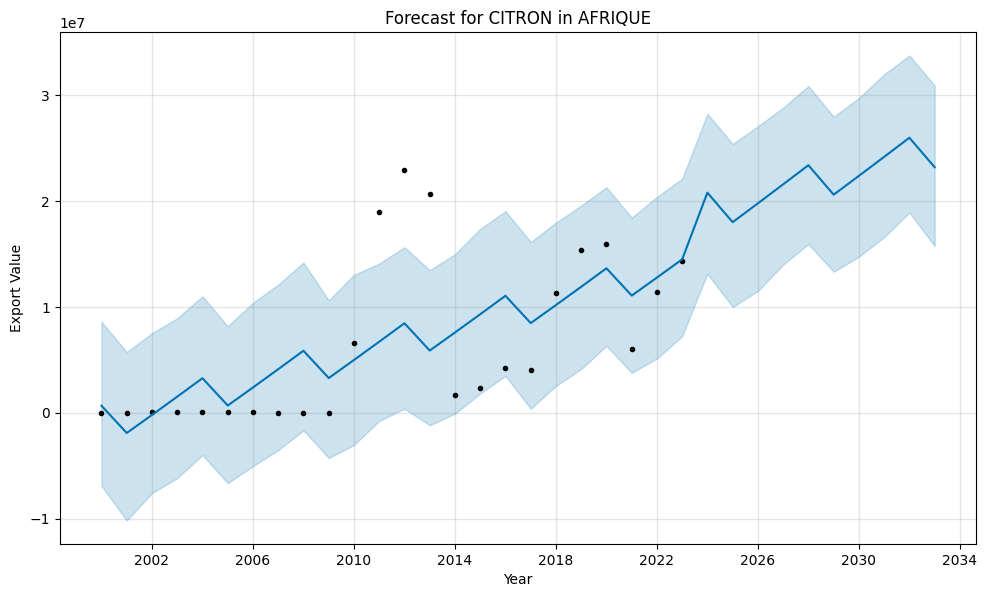

In [85]:


# Prepare the data for Prophet
# We need to transform the data into a long format with columns 'ds' and 'y'
def prepare_data(df, product, continent):
    df_filtered = df[(df['produit'] == product) & (df['Continent'] == continent)]
    value_columns = [col for col in df.columns if col.startswith('valeur_')]
    data_list = []
    for col in value_columns:
        year = col.split('_')[1]
        data_list.append({'ds': f'{year}-01-01', 'y': df_filtered[col].values[0]})
    return pd.DataFrame(data_list)

# Example: Prepare data for CITRON in AFRIQUE
product = 'CITRON'
continent = 'AFRIQUE'
df_prepared = prepare_data(data_continent, product, continent)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_prepared)

# Make a future dataframe for predictions (next 10 years)
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Forecast for {product} in {continent}')
plt.xlabel('Year')
plt.ylabel('Export Value')
plt.show()




1- Prepare Data for Prophet: Define a function to filter and transform the data into a long format suitable for Prophet, with columns 'ds' (date) and 'y' (value).

2- Define Product and Continents: Specify the product and the list of continents for analysis.

3- Initialize Metrics Dictionary: Create dictionaries to store evaluation metrics (MAE, MSE, RMSE) for each continent.

4- Loop through Continents: For each continent, perform the following steps:
- Filter and prepare the data.
- Split the data into training and test sets.
- Initialize and fit the Prophet model using the training data.
- Generate future predictions covering the test period.
- Evaluate the model's performance using MAE, MSE, and RMSE.
- Store the evaluation metrics in the dictionaries.
- Plot the actual vs predicted values for visual comparison.
- Plot the residuals to analyze model errors.
- Perform cross-validation using Prophet's built-in functions to further assess model performance over different time periods and display the results.
5- Visualize Metrics: Convert the metrics dictionary to a DataFrame for better visualization and display the metrics for each continent

03:00:41 - cmdstanpy - INFO - Chain [1] start processing
03:00:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\benzh\AppData\Local\Temp\ipykernel_32808\3525031701.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = forecast['yhat'].tail(len(test)).values


AFRIQUE - MAE: 6986971.039499443
AFRIQUE - MSE: 53705341455703.43
AFRIQUE - RMSE: 7328392.8289703075


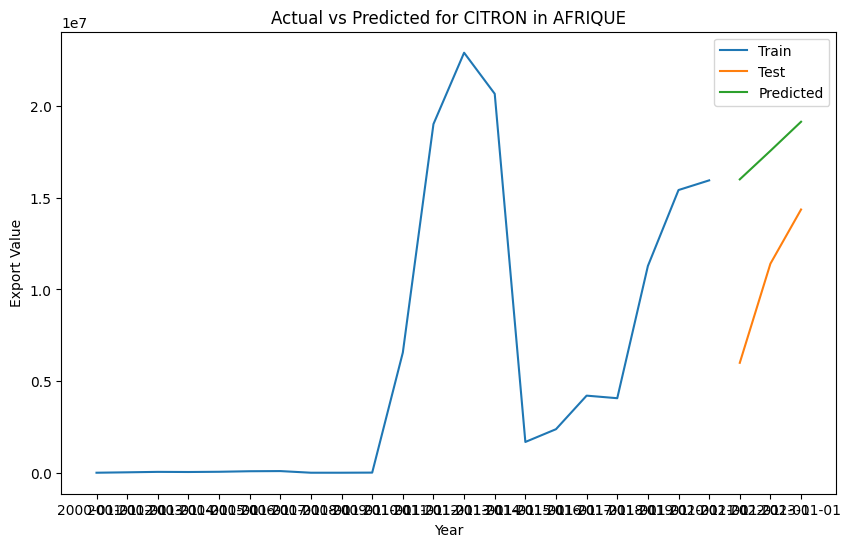

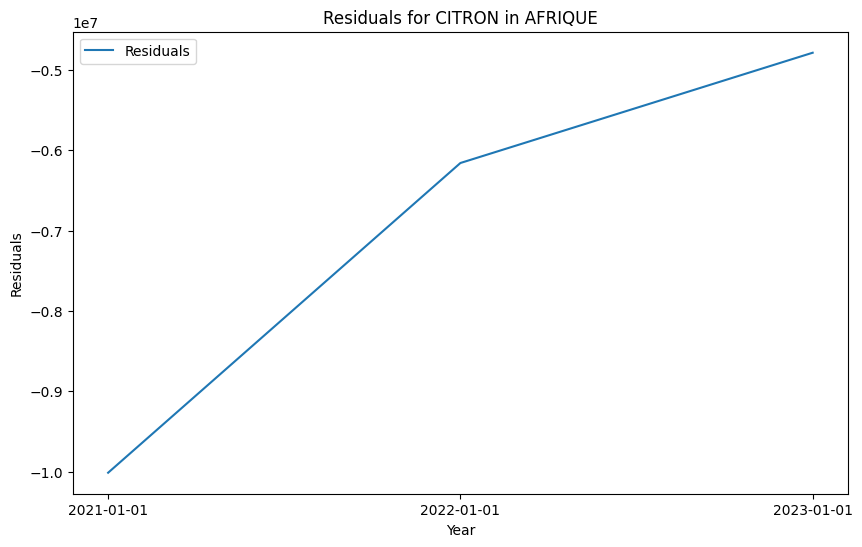

  0%|          | 0/18 [00:00<?, ?it/s]03:00:43 - cmdstanpy - INFO - Chain [1] start processing
03:00:43 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 1/18 [00:00<00:14,  1.21it/s]03:00:43 - cmdstanpy - INFO - Chain [1] start processing
03:00:43 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/18 [00:01<00:11,  1.40it/s]03:00:44 - cmdstanpy - INFO - Chain [1] start processing
03:00:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 3/18 [00:02<00:10,  1.44it/s]03:00:45 - cmdstanpy - INFO - Chain [1] start processing
03:00:45 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 4/18 [00:02<00:09,  1.44it/s]03:00:45 - cmdstanpy - INFO - Chain [1] start processing
03:00:46 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 5/18 [00:03<00:09,  1.43it/s]03:00:46 - cmdstanpy - INFO - Chain [1] start processing
03:00:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 6/18 [00:04<00:08,  1.43it/s]03:00:47

Cross-validation performance for CITRON in AFRIQUE:
   horizon           mse          rmse           mae     mdape     smape  \
0 361 days  5.078991e+08  2.253662e+04  1.654253e+04  0.417657  0.300425   
1 362 days  2.907331e+09  5.391967e+04  3.634958e+04       inf  1.005755   
2 363 days  1.276777e+14  1.129945e+07  9.261323e+06  0.936857  1.520654   
3 364 days  1.471928e+14  1.213230e+07  1.191984e+07  3.892463  1.199785   
4 365 days  1.792220e+13  4.233462e+06  3.387031e+06  0.173184  0.350549   

   coverage  
0       0.5  
1       0.5  
2       0.0  
3       0.0  
4       1.0  


03:00:55 - cmdstanpy - INFO - Chain [1] start processing
03:00:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\benzh\AppData\Local\Temp\ipykernel_32808\3525031701.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = forecast['yhat'].tail(len(test)).values


EUROPE - MAE: 54038206.87616128
EUROPE - MSE: 3147855037073430.5
EUROPE - RMSE: 56105748.698982984


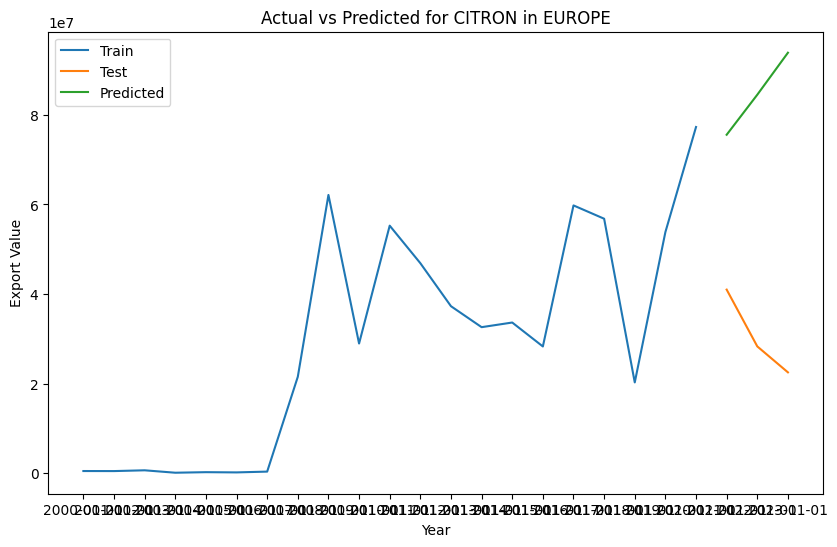

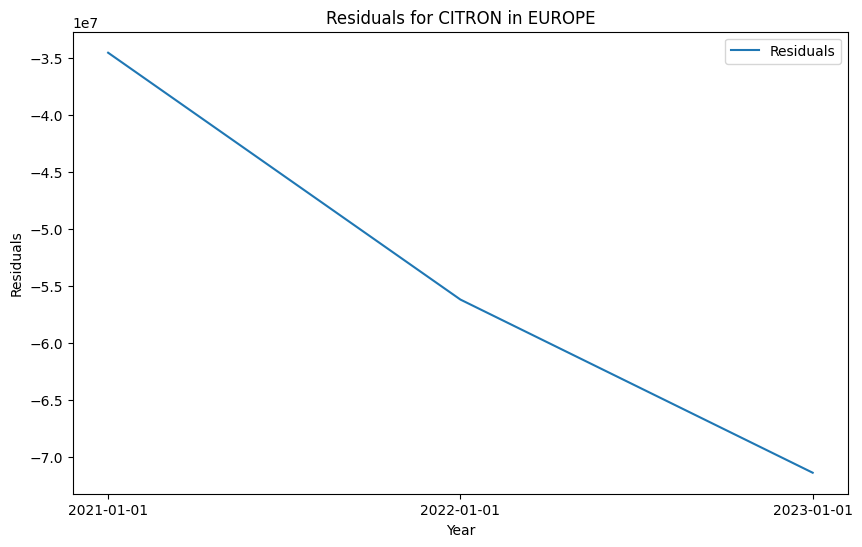

  0%|          | 0/18 [00:00<?, ?it/s]03:00:56 - cmdstanpy - INFO - Chain [1] start processing
03:00:57 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 1/18 [00:00<00:12,  1.31it/s]03:00:57 - cmdstanpy - INFO - Chain [1] start processing
03:00:57 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/18 [00:01<00:11,  1.36it/s]03:00:58 - cmdstanpy - INFO - Chain [1] start processing
03:00:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 3/18 [00:02<00:10,  1.42it/s]03:00:59 - cmdstanpy - INFO - Chain [1] start processing
03:00:59 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 4/18 [00:02<00:09,  1.49it/s]03:00:59 - cmdstanpy - INFO - Chain [1] start processing
03:00:59 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 5/18 [00:03<00:08,  1.49it/s]03:01:00 - cmdstanpy - INFO - Chain [1] start processing
03:01:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 6/18 [00:04<00:07,  1.51it/s]03:01:00

Cross-validation performance for CITRON in EUROPE:
   horizon           mse          rmse           mae      mape     mdape  \
0 361 days  2.703560e+11  5.199577e+05  4.475944e+05  3.574103  3.574103   
1 362 days  7.142412e+14  2.672529e+07  1.768377e+07  0.729536  0.784416   
2 363 days  2.584388e+14  1.607603e+07  1.380892e+07  0.330184  0.260492   
3 364 days  3.335339e+14  1.826291e+07  1.623341e+07  0.512337  0.511623   
4 365 days  4.218891e+14  2.053994e+07  1.579768e+07  0.561984  0.161700   

      smape  coverage  
0  1.401949      0.00  
1  1.215371      0.25  
2  0.308933      0.50  
3  0.382409      0.50  
4  0.344768      0.75  


03:01:08 - cmdstanpy - INFO - Chain [1] start processing
03:01:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\benzh\AppData\Local\Temp\ipykernel_32808\3525031701.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = forecast['yhat'].tail(len(test)).values


ASIE - MAE: 6022691.275348462
ASIE - MSE: 37796404061011.72
ASIE - RMSE: 6147878.012860349


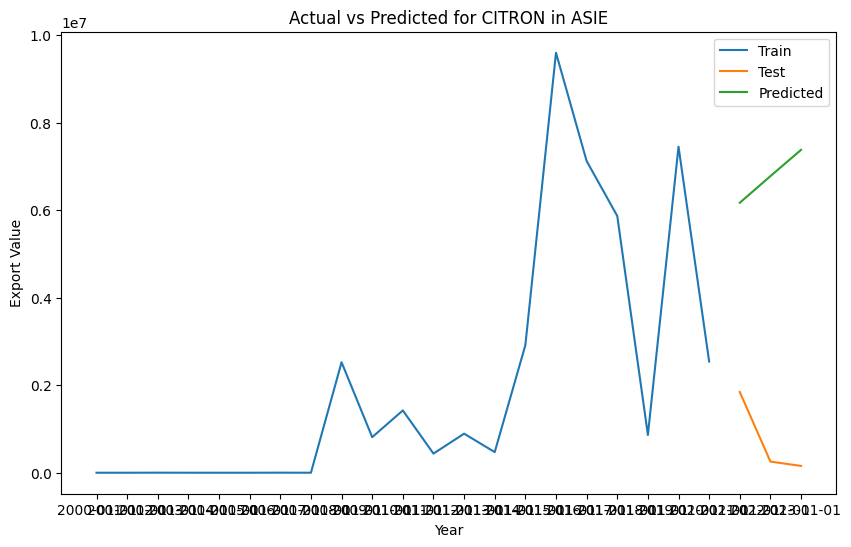

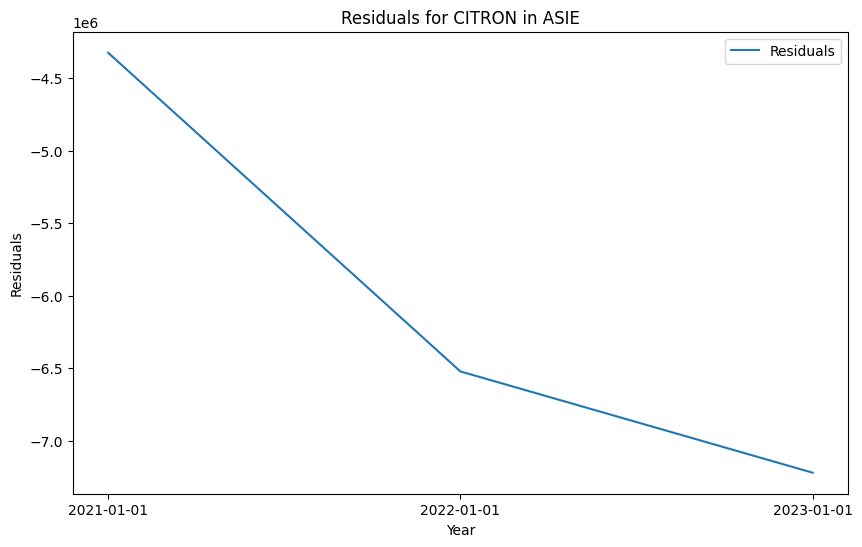

  0%|          | 0/18 [00:00<?, ?it/s]03:01:09 - cmdstanpy - INFO - Chain [1] start processing
03:01:10 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 1/18 [00:00<00:12,  1.34it/s]03:01:10 - cmdstanpy - INFO - Chain [1] start processing
03:01:10 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/18 [00:01<00:10,  1.46it/s]03:01:11 - cmdstanpy - INFO - Chain [1] start processing
03:01:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 3/18 [00:02<00:09,  1.52it/s]03:01:12 - cmdstanpy - INFO - Chain [1] start processing
03:01:12 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 4/18 [00:02<00:09,  1.49it/s]03:01:12 - cmdstanpy - INFO - Chain [1] start processing
03:01:12 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 5/18 [00:03<00:08,  1.58it/s]03:01:13 - cmdstanpy - INFO - Chain [1] start processing
03:01:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 6/18 [00:03<00:07,  1.62it/s]03:01:13

Cross-validation performance for CITRON in ASIE:
   horizon           mse          rmse           mae     mdape     smape  \
0 361 days  2.988511e+06  1.728731e+03  1.507040e+03       inf  1.867354   
1 362 days  1.592436e+12  1.261917e+06  6.315994e+05       inf  1.905691   
2 363 days  4.670991e+11  6.834465e+05  5.656877e+05  0.467521  0.530321   
3 364 days  1.790813e+13  4.231800e+06  3.222755e+06  0.718944  0.876142   
4 365 days  1.110827e+13  3.332907e+06  3.135853e+06  0.954783  0.762423   

   coverage  
0      0.00  
1      0.00  
2      0.75  
3      0.25  
4      0.50  
  continent           MAE           MSE          RMSE
0   AFRIQUE  6.986971e+06  5.370534e+13  7.328393e+06
1    EUROPE  5.403821e+07  3.147855e+15  5.610575e+07
2      ASIE  6.022691e+06  3.779640e+13  6.147878e+06


In [87]:


# Prepare the data for Prophet
def prepare_data(df, product, continent):
    df_filtered = df[(df['produit'] == product) & (df['Continent'] == continent)]
    value_columns = [col for col in df.columns if col.startswith('valeur_')]
    data_list = []
    for col in value_columns:
        year = col.split('_')[1]
        data_list.append({'ds': f'{year}-01-01', 'y': df_filtered[col].values[0]})
    return pd.DataFrame(data_list)

# Define the product and continents
product = 'CITRON'
continents = ['AFRIQUE', 'EUROPE', 'ASIE']

# Dictionaries to store the metrics
metrics = {'continent': [], 'MAE': [], 'MSE': [], 'RMSE': []}

# Loop through each continent and perform the analysis
for continent in continents:
    df_prepared = prepare_data(data_continent, product, continent)

    # Split the data into training and test sets
    train = df_prepared[df_prepared['ds'] < '2021-01-01']
    test = df_prepared[df_prepared['ds'] >= '2021-01-01']

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train)

    # Make a future dataframe for predictions (covering the test period)
    future = model.make_future_dataframe(periods=len(test), freq='Y')
    forecast = model.predict(future)

    # Evaluate the model
    test['yhat'] = forecast['yhat'].tail(len(test)).values
    mae = mean_absolute_error(test['y'], test['yhat'])
    mse = mean_squared_error(test['y'], test['yhat'])
    rmse = np.sqrt(mse)

    # Store the metrics
    metrics['continent'].append(continent)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['RMSE'].append(rmse)

    print(f'{continent} - MAE: {mae}')
    print(f'{continent} - MSE: {mse}')
    print(f'{continent} - RMSE: {rmse}')

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(train['ds'], train['y'], label='Train')
    plt.plot(test['ds'], test['y'], label='Test')
    plt.plot(test['ds'], test['yhat'], label='Predicted')
    plt.xlabel('Year')
    plt.ylabel('Export Value')
    plt.title(f'Actual vs Predicted for {product} in {continent}')
    plt.legend()
    plt.show()

    # Plot residuals
    residuals = test['y'] - test['yhat']
    plt.figure(figsize=(10, 6))
    plt.plot(test['ds'], residuals, label='Residuals')
    plt.xlabel('Year')
    plt.ylabel('Residuals')
    plt.title(f'Residuals for {product} in {continent}')
    plt.legend()
    plt.show()

    # Use Prophet's built-in cross-validation
    from prophet.diagnostics import cross_validation, performance_metrics

    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days')
    df_p = performance_metrics(df_cv)

    print(f'Cross-validation performance for {product} in {continent}:')
    print(df_p.head())

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
